In [19]:
import tensorflow as tf 
from keras.layers import Input, Conv1D, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, MaxPooling1D, concatenate, Dropout
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import os
import pickle
import matplotlib.pyplot as plt

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import librosa
import keras
from sklearn.preprocessing import LabelEncoder
import sklearn
import itertools
from scipy.signal import find_peaks
import xgboost as xgb
import random

In [36]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualizePCA2D(X , y , colors=None):

    pca = TSNE(n_components=2)
    principalComponents = pca.fit_transform(X)
    principalDf = pd.DataFrame(data = principalComponents
                , columns = ['principal component 1', 'principal component 2'])
    # principalDf.head(5)

    #%%
    targetDf = pd.DataFrame(data = np.array(y) , columns = ['target'])
    # targetDf.head()

    #%%
    finalDf = pd.concat([principalDf, targetDf], axis = 1)
    print(finalDf.head(5))

    #%%
    # Visualize data
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 Component PCA', fontsize = 20)


    targets = list(set(y))

    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['target'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                , finalDf.loc[indicesToKeep, 'principal component 2']
                , c = color
                , s = 50)
    ax.legend(targets)
    ax.grid()

# Dataset Loading and Preprocessing

In [35]:
def processPeaks(signal , plot = False):

    peaks, _ = find_peaks(signal, height=0)

    if(plot == True):
        plt.plot(signal)
        print(peaks)

    peak_cnt = len(peaks)
    peak_diff = 0
    for i in range(len(peaks)):
        if(i == 0):
            peak_diff += peaks[i] - 0
        else:
            peak_diff += peaks[i] - peaks[i-1]
    
    if(peak_cnt > 0): 
        peak_diff /= len(peaks)

    return peak_cnt, peak_diff

def preprocessOneVector(feature_vec):
    ax = []
    ay = []
    az = []
    for i in range(feature_vec.shape[0]):
        ax.append(feature_vec[i]['acc_x'])
        ay.append(feature_vec[i]['acc_y'])
        az.append(feature_vec[i]['acc_z'])

    fft_ax = np.fft.fft(ax)
    fft_ay = np.fft.fft(ay)
    fft_az = np.fft.fft(az)

    # MEAN
    ax_mean = np.mean(ax)
    ay_mean = np.mean(ay)
    az_mean = np.mean(az)
    fft_ax_mean = np.mean(fft_ax)
    fft_ay_mean = np.mean(fft_ay)
    fft_az_mean = np.mean(fft_az)

    # MEDIAN
    ax_median = np.median(ax)
    ay_median = np.median(ay)
    az_median = np.median(az)
    fft_ax_median = np.median(fft_ax)
    fft_ay_median = np.median(fft_ay)
    fft_az_median = np.median(fft_az)

    # MAGNITUDE
    mag = 0
    for i in range(feature_vec.shape[0]):
        val = 0
        val += feature_vec[i]['acc_x'] * feature_vec[i]['acc_x'] 
        val += feature_vec[i]['acc_y'] * feature_vec[i]['acc_y'] 
        val += feature_vec[i]['acc_z'] * feature_vec[i]['acc_z'] 
        mag += math.sqrt(val)
    mag /= feature_vec.shape[0]

    # CROSS-CORRELATION
    Corr_xz = np.correlate(ax , az)
    Corr_yz = np.correlate(ay , az)


    # AVG DIFF FROM MEAN
    avg_diff_x = 0
    avg_diff_y = 0
    avg_diff_z = 0
    for i in range(feature_vec.shape[0]):
        avg_diff_x += abs(ax_mean - ax[i])
        avg_diff_y += abs(ay_mean - ay[i])
        avg_diff_z += abs(az_mean - az[i])

    avg_diff_x /= feature_vec.shape[0]
    avg_diff_y /= feature_vec.shape[0]
    avg_diff_z /= feature_vec.shape[0]

    # SPECTRAL CENTROID
    spc_x = librosa.feature.spectral_centroid(np.array(ax))[0][0]
    spc_y = librosa.feature.spectral_centroid(np.array(ay))[0][0]
    spc_z = librosa.feature.spectral_centroid(np.array(az))[0][0]

    # PEAKS
    x_peak_cnt , x_peak_diff = processPeaks(ax)
    y_peak_cnt , y_peak_diff = processPeaks(ay)
    z_peak_cnt , z_peak_diff = processPeaks(az)


    feature_processed = [
        ax_mean, ay_mean, az_mean,
        fft_ax_mean.real, fft_ax_mean.imag, fft_ay_mean.real, fft_ay_mean.imag, 
        fft_az_mean.real, fft_az_mean.imag,

        ax_median, ay_median, az_median,
        fft_ax_median.real, fft_ax_median.imag, fft_ay_median.real, fft_ay_median.imag, 
        fft_az_median.real, fft_az_median.imag,

        mag,

        Corr_xz, Corr_yz,

        avg_diff_x, avg_diff_y, avg_diff_z,

        spc_x, spc_y , spc_z,

        # x_peak_cnt, x_peak_diff, y_peak_cnt, y_peak_diff, z_peak_cnt, z_peak_diff 
    ]

    return feature_processed

In [37]:
import json
def loadJSONDataset(file_name):
    with open(file_name) as f:
        data = json.load(f)
    arr = np.array(json.loads(data[0]['vector']))
    print(arr)
    print(type(arr) , arr.shape)

    data_acc = []
    for reading in data:
        if(reading["sensor"] != "Accelerometer"):
            continue
        arr = np.array(json.loads(reading['vector']))
        data_acc.append({
            'acc_x': arr[0],
            'acc_y': arr[1],
            'acc_z': arr[2]
        })
    return np.array(data_acc)

def segmentaizeData(data_acc, block_size=100, interval=100):
    data_seg = []
    st = 0
    while(st + block_size < len(data_acc)):
        nd = st + block_size
        data_seg.append(data_acc[st:nd])
        st = st + interval
    data_seg = np.array(data_seg)
    return data_seg

def extractFeatureFromSegmentizeData(data_seg):
    data_feature = []
    for i in range(data_seg.shape[0]):
        feature_clean = preprocessOneVector(data_seg[i])
        data_feature.append(feature_clean)
    data_feature = np.array(data_feature)
    return data_feature

In [38]:
def loadNewData(user_data , folder_name):
    X = []
    y = []
    for (user_name, st, nd) in user_data:
        for i in range(st,nd+1):
            file_name = folder_name + '/'+user_name+str(i)+'.json'
            data = loadJSONDataset(file_name)
            data_seg = segmentaizeData(data, block_size=300, interval=50)
            data_feature = extractFeatureFromSegmentizeData(data_seg)

            print(user_name , i , "::", nd , data_feature.shape)
            for i in range(len(data_feature)):
                X.append(data_feature[i])
                y.append(user_name)
    
    zz = list(zip(X,y))
    random.shuffle(zz)
    X,y = zip(*zz)

    return np.array(X) , np.array(y)


In [39]:
print('loading dataset')
user_data = [
    ('Razzak', 1,  3),
    ('Tipu',1 , 3),
    ('Sajib',1 , 3),
    ('Tuhin', 1, 3),
    ('Nayeem', 1, 3)
]

X_train, y_train = loadNewData(user_data , "new_data_A1")
print('>>>>>>>>>>>>>>>>>>>>>>>>> loaded train dataset :: ' , X_train.shape , y_train.shape)

loading dataset
[58.]
<class 'numpy.ndarray'> (1,)
Razzak 1 :: 3 (120, 27)
[159.]
<class 'numpy.ndarray'> (1,)
Razzak 2 :: 3 (163, 27)
[45.]
<class 'numpy.ndarray'> (1,)
Razzak 3 :: 3 (157, 27)
[238.]
<class 'numpy.ndarray'> (1,)
Tipu 1 :: 3 (170, 27)
[248.]
<class 'numpy.ndarray'> (1,)
Tipu 2 :: 3 (177, 27)
[43.]
<class 'numpy.ndarray'> (1,)
Tipu 3 :: 3 (169, 27)
[302.]
<class 'numpy.ndarray'> (1,)
Sajib 1 :: 3 (131, 27)
[506.]
<class 'numpy.ndarray'> (1,)
Sajib 2 :: 3 (161, 27)
[204.]
<class 'numpy.ndarray'> (1,)
Sajib 3 :: 3 (131, 27)
[233.]
<class 'numpy.ndarray'> (1,)
Tuhin 1 :: 3 (102, 27)
[168.]
<class 'numpy.ndarray'> (1,)
Tuhin 2 :: 3 (134, 27)
[102.]
<class 'numpy.ndarray'> (1,)
Tuhin 3 :: 3 (150, 27)
[164.]
<class 'numpy.ndarray'> (1,)
Nayeem 1 :: 3 (164, 27)
[117.]
<class 'numpy.ndarray'> (1,)
Nayeem 2 :: 3 (172, 27)
[271.]
<class 'numpy.ndarray'> (1,)
Nayeem 3 :: 3 (167, 27)
>>>>>>>>>>>>>>>>>>>>>>>>> loaded train dataset ::  (2268, 27) (2268,)


In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=31)

print("Train", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)

Train (1519, 27) (1519,)
Test (749, 27) (749,)


   principal component 1  principal component 2  target
0              12.010174             -22.317202  Razzak
1              37.357662              -4.431365  Nayeem
2             -20.132324              12.548852   Sajib
3              -9.182069              48.305981    Tipu
4              -8.460018              52.058678    Tipu


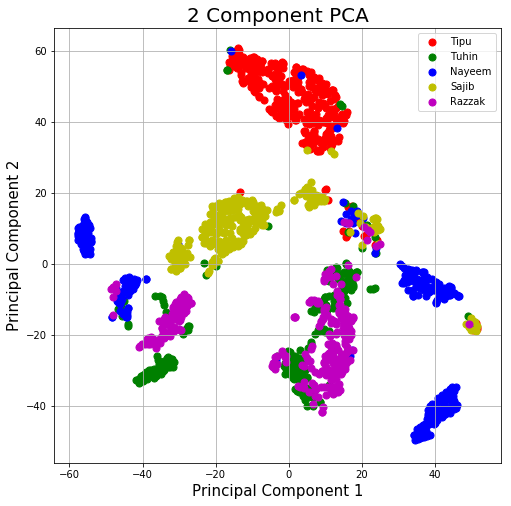

In [41]:
visualizePCA2D(X_train , y_train , colors = ['r' , 'g' , 'b' , 'y' , 'm'])

   principal component 1  principal component 2  target
0             -32.077923               7.006329    Tipu
1              -9.756920             -12.196716   Sajib
2               8.284704             -34.840183  Razzak
3              31.928621              15.890741   Tuhin
4             -29.211664               8.805850    Tipu


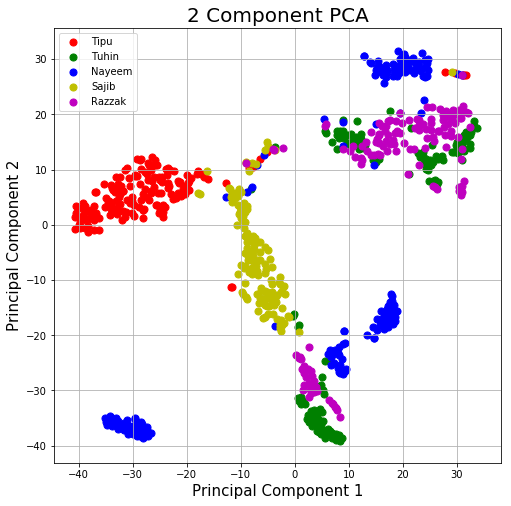

In [42]:
visualizePCA2D(X_test , y_test , colors = ['r' , 'g' , 'b' , 'y' , 'm'])

# Model Structure and Loading

In [34]:
import scipy
from keras.layers import merge

def cos_distance(y_true, y_pred):
    y_true = K.l2_normalize(y_true, axis=-1)
    y_pred = K.l2_normalize(y_pred, axis=-1)
    return K.mean(1 - K.sum((y_true * y_pred), axis=-1))

def triplet_loss(y_true, y_pred, alpha = 10000000000):

#     print('y_pred.shape = ',y_pred.shape)
    
    total_lenght = y_pred.shape.as_list()[-1]
#     print('total_lenght=',  total_lenght)
    
    anchor = y_pred[:,0:int(total_lenght*1/3)]
    positive = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
    negative = y_pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]

    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)
#     pos_cos  = cos_distance(anchor, positive)
#     pos_dist = pos_cos

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)
#     neg_cos  = cos_distance(anchor, negative)
#     neg_dist = neg_cos
    
#     print(pos_cos.eval() , neg_cos.eval())
#     print(pos_dist.eval() , neg_dist.eval())
    
    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    
    loss = K.maximum(basic_loss,0.0)
    
    no_tune = pos_dist - neg_dist 
    
#     print(">>> ", basic_loss.eval(), loss.eval(), no_tune.eval())

    
    return loss

In [50]:
def create_2D_network(in_dims):
    print(in_dims , type(in_dims))
    
    model = Sequential()
    model.add(Conv2D(128,(7,7),padding='same',input_shape=(in_dims[0], in_dims[1], in_dims[2]),activation='relu',name='conv1'))
    model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool1'))
    model.add(Conv2D(256,(5,5),padding='same',activation='relu',name='conv2'))
    model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool2'))
    model.add(Dropout(0.2))
    model.add(Flatten(name='flatten'))
    model.add(Dense(400, activation='relu', name='seq_1'))
    model.add(Dropout(0.2))
    model.add(Dense(250, activation='relu', name='seq_2'))
    model.add(Dense(25,name='embeddings'))
    
    return model

In [51]:
def create_2D_network_20_15(in_dims):
    print(in_dims , type(in_dims))
    
    model = Sequential()
    model.add(Conv2D(50,(3,3),padding='same',input_shape=(in_dims[0], in_dims[1], in_dims[2]),activation='relu',name='conv1'))
    model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool1'))
    model.add(Conv2D(100,(5,5),padding='same',activation='relu',name='conv2'))
    model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool2'))
    model.add(Dropout(0.2))
    model.add(Flatten(name='flatten'))
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(150, activation='relu'))
    model.add(Dense(20,name='embeddings'))
    
    return model

In [52]:
adam_optim = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)

In [53]:
shape = (3,3,3)

anchor_input = Input(shape, name='anchor_input')
positive_input = Input(shape, name='positive_input')
negative_input = Input(shape, name='negative_input')

# Shared embedding layer for positive and negative items
Shared_DNN = create_2D_network_20_15(shape)


encoded_anchor = Shared_DNN(anchor_input)
encoded_positive = Shared_DNN(positive_input)
encoded_negative = Shared_DNN(negative_input)


merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')

model = Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
model.compile(loss=triplet_loss, optimizer=adam_optim)

(3, 3, 3) <class 'tuple'>


In [54]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 3, 3, 3)      0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 3, 3, 3)      0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 3, 3, 3)      0                                            
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 20)           179870      anchor_input[0][0]               
                                                                 positive_input[0][0]             
          

In [76]:
trained_model = Model(inputs=anchor_input, outputs=encoded_anchor)
trained_model.load_weights('model_20_5/weights-improvement-50-160417657.58.hdf5')

# Check model performance

In [77]:
X_train_trm = trained_model.predict(X_train.reshape([-1]+list(shape)))
X_test_trm = trained_model.predict(X_test.reshape([-1]+list(shape)))

   principal component 1  principal component 2  target
0              10.109519              47.314121  Razzak
1              17.060810             -53.196751  Nayeem
2             -24.527466             -16.927320   Sajib
3              35.798779              -8.177475    Tipu
4              50.740849               2.747506    Tipu


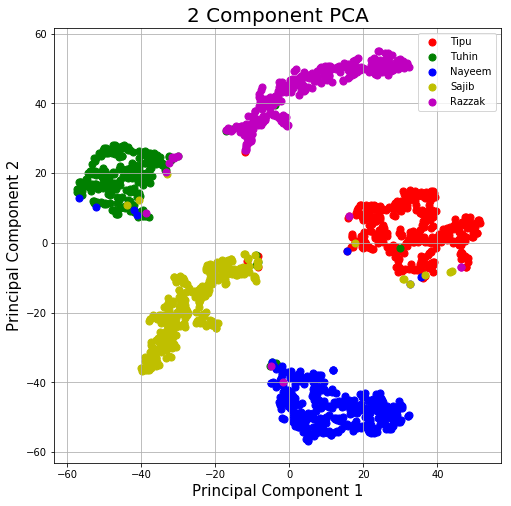

In [78]:
visualizePCA2D(X_train_trm , y_train , colors = ['r' , 'g' , 'b' , 'y' , 'm'])

   principal component 1  principal component 2  target
0              -0.518004              31.808239    Tipu
1              49.967976              16.309925   Sajib
2             -38.683861               0.140278  Razzak
3              -8.642701             -34.421875   Tuhin
4              -1.169705              27.209267    Tipu


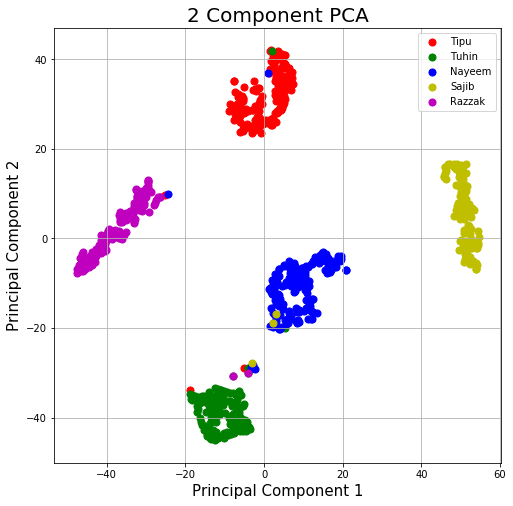

In [79]:
visualizePCA2D(X_test_trm , y_test , colors = ['r' , 'g' , 'b' , 'y' , 'm'])